In [1]:
from sklearn.metrics import confusion_matrix, classification_report 
def scoreCalculator(predictor, attributes, labels):
    predicted = predictor.predict(attributes)
    errorScore = 0
    for guessIndex in range(len(predicted)):
        guess = predicted[guessIndex]
        actual = labels[guessIndex]
        if guess == 'hold' :
            errorScore += 0
        elif guess == 'long':
            if actual == 'short':
                errorScore += -15
            elif actual == 'hold':
                errorScore += -5
            else :#actual == 'long'
                errorScore += 20
        else: #short
            if actual == 'long':
                errorScore += -20
            elif actual == 'hold':
                errorScore += 0
            else: #actual == short
                errorScore += 20
    myMatrix = confusion_matrix(labels, predicted,normalize = 'all')     
    return  errorScore/len(predicted), myMatrix

In [2]:
from tabulate import tabulate
def catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer,sector, catLabels):
    catIndicies = []
    counter = -1
    for col in sectorDF.columns: #finding indices for cat variables
        counter += 1
        if col in catLabels:
            catIndicies.append(counter)
    masterList = sectorDF.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList =\
    train_test_split(masterList,zScoreAnswer,fiveDayChangeAnswer,test_size = .3)

    trainPools = [Pool(data = masterTrainList, label = zScoreTrainList, cat_features = catIndicies),
    Pool(data = masterTrainList, label = fiveDayChangeTrainList, cat_features = catIndicies)]
    testPools = [Pool(data = masterTestList, label = zScoreTestList, cat_features = catIndicies),
    Pool(data = masterTestList, label = fiveDayChangeTestList, cat_features = catIndicies)]
    modelNames = ['ZScorePredictor','FiveDayPredictor']
    folderRoot = 'catPredictors/'
    accuracyList = []
    scoreList = []
    print('Catboost:')
    for name, train, test in zip(modelNames, trainPools, testPools):
        train.set_feature_names([x for x in sectorDF.columns])
        print(name)
        model = CatBoostClassifier(bootstrap_type = 'Bernoulli')
        model.fit(train, eval_set = test, logging_level = 'Silent')
        sector = sector.replace(' ', '_')
        model.save_model(folderRoot + name + sector + '.cbm')
        accuracy =  model.score(test)
        print('Accuracy: ', accuracy)
        print(CatBoostClassifier.get_feature_importance(model, prettified = True))
        error, matrix = scoreCalculator(model, test,test.get_label())
        print('Error Score:', error)
        print('Confusion matrix:\n', matrix)
        accuracyList.append(accuracy)
        scoreList.append(error)
        
    averageAccuracy = sum([x for x in accuracyList])/len(accuracyList)
    averageScore = sum([x for x in scoreList])/len(scoreList)
    return averageAccuracy, averageScore

In [3]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import json
import os
from tabulate import tabulate

def sciKitPredictionMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer,sector, catLabels):

    folderRoot = 'sciKitPredictors/'
    print('\nSci-Kit:')
    sectorDF.drop(columns = catLabels, inplace = True)
    masterList = sectorDF.values
    masterTrainList, masterTestList, zScoreTrainList, zScoreTestList, fiveDayChangeTrainList, fiveDayChangeTestList =\
    train_test_split(masterList,zScoreAnswer,fiveDayChangeAnswer,test_size = .3)
    
    
    hyperParamDict = {'accuracy': 0,
    'error_score': -np.inf,
    'min_samples_split': 5,
    'min_impurity_decrease': 0}
    min_samples_splitChoices = [5,15,20,50,100]
    min_impurity_decreaseChoices = [ 0.00001,0,0.0001, 0.001, 0.01, 0.05]
    trainTestBundles = [['zScore', zScoreTrainList, zScoreTestList, hyperParamDict.copy()],
    ['fiveDay',fiveDayChangeTrainList, fiveDayChangeTestList, hyperParamDict.copy()]]

    for minSplit in min_samples_splitChoices:
        for minImpurity in min_impurity_decreaseChoices:
            for bundle in trainTestBundles:
                errorScoreList = []
                accuracyList = []
                for randState in range(3):
                    predictor = RandomForestClassifier(min_samples_split = minSplit, min_impurity_decrease = minImpurity,
                        random_state = randState, n_jobs = 2)
                    predictor.fit(masterTrainList, bundle[1])
                    predictions = predictor.predict(masterTestList)
                    predictionAccuracy = accuracy_score(bundle[2],predictions)
                    feature = pd.DataFrame(predictor.feature_importances_,
                                                        index = sectorDF.columns,
                                                        columns=['importance']).sort_values('importance', ascending=False)
                    errorScore, _ = scoreCalculator(predictor, masterTestList, zScoreTestList)
                    errorScoreList.append(errorScore)
                    accuracyList.append(predictionAccuracy)
                errorScore = sum(errorScoreList)/len(errorScoreList)
                predictionAccuracy = sum(accuracyList)/len(accuracyList)
                if errorScore > bundle[3]['error_score']:
                    bundle[3]['accuracy'] = predictionAccuracy
                    bundle[3]['error_score'] = errorScore
                    bundle[3]['min_samples_split'] = minSplit
                    bundle[3]['min_impurity_decrease'] = minImpurity
    print('Final result:')
    print(trainTestBundles[0][0], ' ', trainTestBundles[0][3])
    print(trainTestBundles[1][0], ' ',trainTestBundles[1][3])
    for bundle in trainTestBundles:
        print('bundle')
        predictor = RandomForestClassifier(min_samples_split = bundle[3]['min_samples_split'], 
        min_impurity_decrease = bundle[3]['min_impurity_decrease'], random_state = 1, n_jobs = 2)
        predictor.fit(masterTrainList, bundle[1])
        
        headers = ["name", "score"]
        values = sorted(zip(sectorDF.columns, predictor.feature_importances_), key=lambda x: x[1] * -1)
        print(tabulate(values, headers, tablefmt="plain"))
        
        _, matrix = scoreCalculator(predictor, masterTestList, zScoreTestList)
        print(bundle[0], ' confusion matrix\n',matrix)
        sector = sector.replace(' ', '_')
        pickle.dump(predictor, open(folderRoot + bundle[0] + sector + '.pkl', 'wb'))
    averageAccuracy = sum([trainTestBundles[x][3]['accuracy'] for x in range(len(trainTestBundles))])/len(trainTestBundles)
    averageScore = sum([trainTestBundles[x][3]['error_score'] for x in range(len(trainTestBundles))])/len(trainTestBundles)
    return averageAccuracy, averageScore

VolumeZScoreTenDay
highVsLowPerc
dayPercentChange
ticker
fiveVSTenDayWeightedAverage
fiveVsTenDaySlopeChange
fiveVsTenDayAverage
MACD
bPercent
rsi
slowVSFastKAMA
aroon
bop
MFI
WilliamsR
zScoreOfChangeTmmrw
percentChangeInFiveDays
typPrice
GICS Sector
GICS Sub Industry
thisDayZScore
totalVolumeOfTheDay
titleSent
articleSent
titleSentChangeSinceYesterday
articleSentChangeSinceYesterday
titleSentbPercent
articleSentbPercent
DTWEXAFEGSValue
DTWEXAFEGSlastChangeP
DTWEXAFEGSfiveVsTenTickAverage
DTWEXAFEGSbPercent
DPRIMEValue
DPRIMElastChangeP
DPRIMEfiveVsTenTickAverage
DPRIMEbPercent
TOTCIValue
TOTCIlastChangeP
TOTCIfiveVsTenTickAverage
TOTCIbPercent
UNRATEValue
UNRATElastChangeP
UNRATEfiveVsTenTickAverage
UNRATEbPercent
CONSUMERValue
CONSUMERlastChangeP
CONSUMERfiveVsTenTickAverage
CONSUMERbPercent
BUSLOANSValue
BUSLOANSlastChangeP
BUSLOANSfiveVsTenTickAverage
BUSLOANSbPercent
CCLACBW027SBOGValue
CCLACBW027SBOGlastChangeP
CCLACBW027SBOGfiveVsTenTickAverage
CCLACBW027SBOGbPercent
STLFSI2Valu

VolumeZScoreTenDay
highVsLowPerc
ticker
MACD
bPercent
slowVSFastKAMA
aroon
MFI
zScoreOfChangeTmmrw
percentChangeInFiveDays
GICS Sector
GICS Sub Industry
thisDayZScore
totalVolumeOfTheDay
articleSent
DTWEXAFEGSlastChangeP
DTWEXAFEGSfiveVsTenTickAverage
DTWEXAFEGSbPercent
DPRIMEValue
DPRIMElastChangeP
DPRIMEbPercent
TOTCIValue
TOTCIlastChangeP
TOTCIfiveVsTenTickAverage
TOTCIbPercent
UNRATEValue
UNRATEfiveVsTenTickAverage
CONSUMERValue
CONSUMERlastChangeP
CONSUMERfiveVsTenTickAverage
CONSUMERbPercent
BUSLOANSValue
BUSLOANSfiveVsTenTickAverage
BUSLOANSbPercent
CCLACBW027SBOGValue
CCLACBW027SBOGlastChangeP
STLFSI2Value
STLFSI2lastChangeP
STLFSI2fiveVsTenTickAverage
STLFSI2bPercent
PRS85006092Value
PRS85006092lastChangeP
PRS85006092bPercent
TCUValue
TCUlastChangeP
TCUfiveVsTenTickAverage
TCUbPercent
BOPGSTBValue
BOPGSTBlastChangeP
BOPGSTBbPercent
CPIAUCSLValue
CPIAUCSLfiveVsTenTickAverage
CPIAUCSLbPercent
SFTPINDM114SFRBSFValue
SFTPINDM114SFRBSFlastChangeP
SFTPINDM114SFRBSFfiveVsTenTickAvera

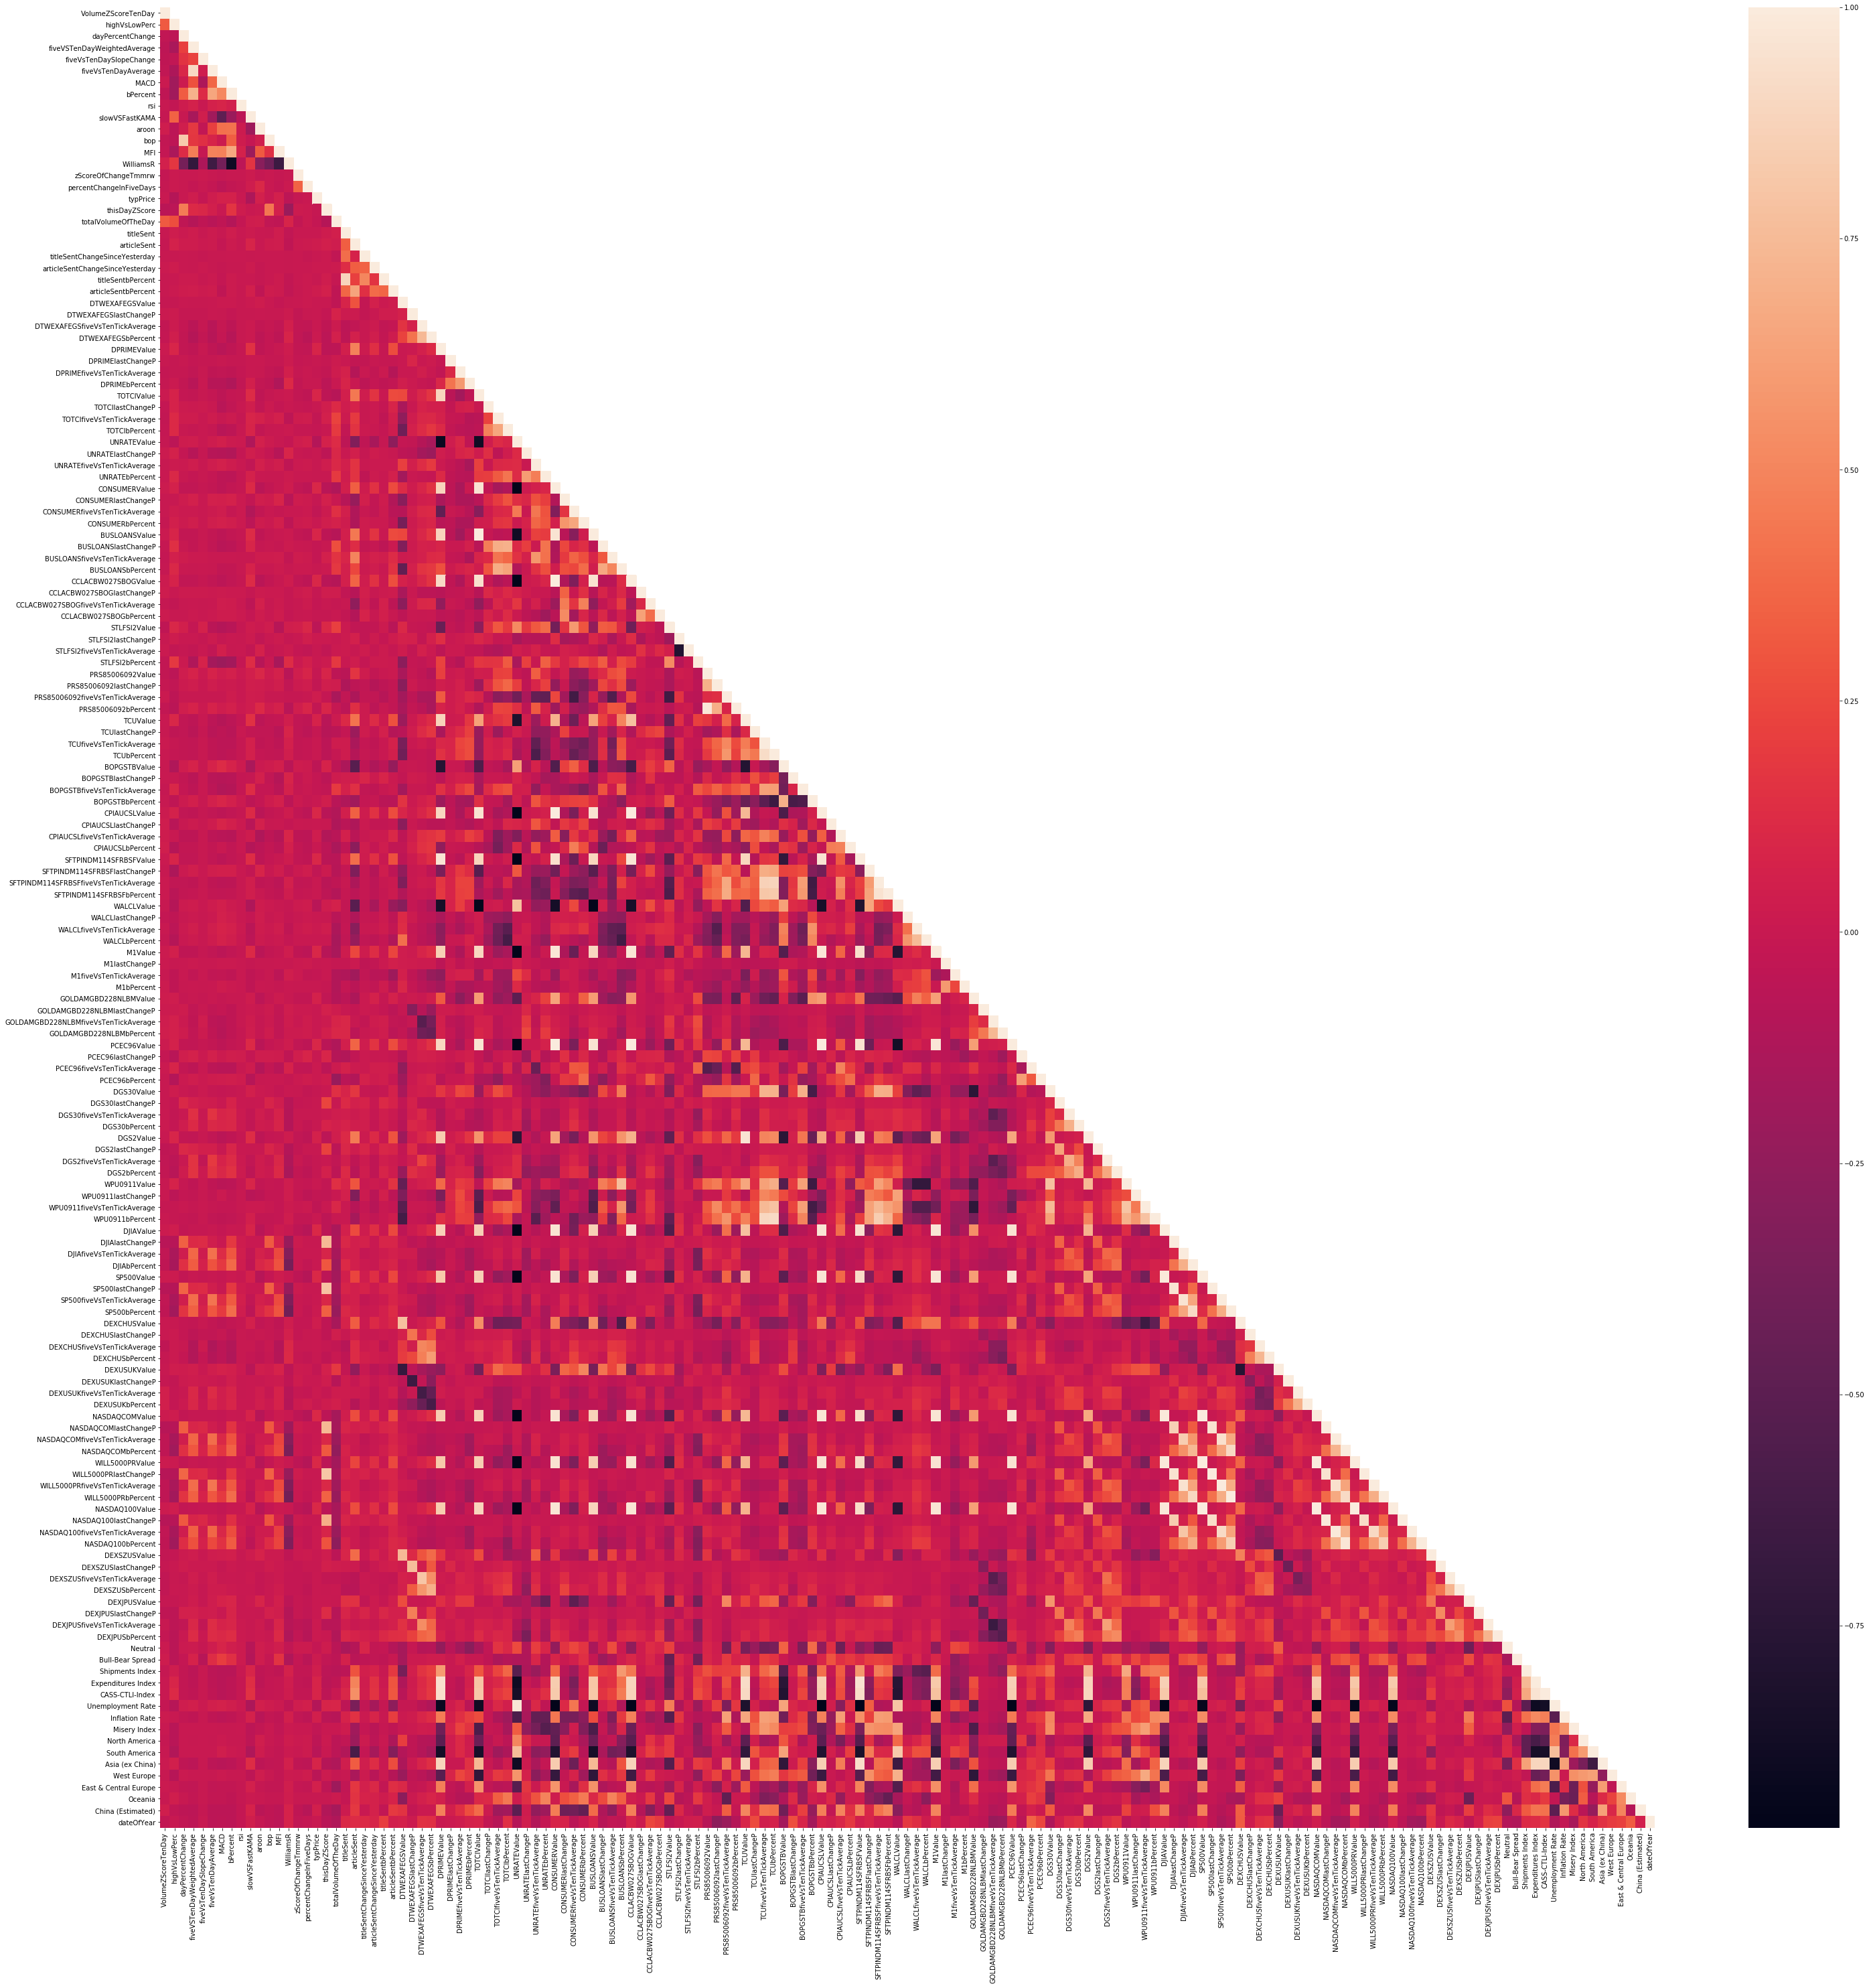

-------------------------------------------


Sector is:  Health Care
Catboost:
ZScorePredictor
Accuracy:  0.607977486846935
                                Feature Id  Importances
0                           slowVSFastKAMA     3.603130
1                            highVsLowPerc     3.538405
2                                 bPercent     2.916163
3                       VolumeZScoreTenDay     2.840132
4                      totalVolumeOfTheDay     2.518119
5                       DEXCHUSlastChangeP     2.435305
6                        GICS Sub Industry     2.385092
7                                      MFI     2.286161
8                                     MACD     2.284255
9                         DGS30lastChangeP     1.883846
10                         DJIAlastChangeP     1.810733
11                                   aroon     1.734617
12                           thisDayZScore     1.731292
13                      DEXSZUSlastChangeP     1.730388
14                         DGS2last

Error Score: 6.1489049308699375
Confusion matrix:
 [[0.26703781 0.08466903 0.05236755]
 [0.10271626 0.2212162  0.01688486]
 [0.08693258 0.02508259 0.14309311]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.604000978832742, 'error_score': 3.413781149312778, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.5996574085403157, 'error_score': 1.4755903584974916, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
slowVSFastKAMA                         0.0939647
highVsLowPerc                          0.0934492
VolumeZScoreTenDay                     0.0897157
bPercent                               0.089452
MACD                                   0.0879692
MFI                                    0.0873299
aroon                                  0.0765705
totalVolumeOfTheDay                    0.00832776
thisDayZScore                          0.00688483
DEXJPUSlastChangeP                     0.00643442
GOLDA

fiveDay  confusion matrix
 [[0.25100942 0.16805335 0.09513031]
 [0.09139851 0.1151352  0.03768506]
 [0.10577511 0.05646641 0.07934663]]
-------------------------------------------


Sector is:  Industrials
Catboost:
ZScorePredictor
Accuracy:  0.6310734463276836
                                Feature Id  Importances
0                            highVsLowPerc     3.359461
1                           slowVSFastKAMA     2.926550
2              GOLDAMGBD228NLBMlastChangeP     2.484938
3                       VolumeZScoreTenDay     2.467815
4                      totalVolumeOfTheDay     2.318732
5                          DGS2lastChangeP     2.309133
6                       DEXUSUKlastChangeP     2.233913
7                                      MFI     2.167320
8                                     MACD     2.110552
9                        GICS Sub Industry     2.090161
10                                bPercent     1.887140
11                            DGS2bPercent     1.787107
12        

Error Score: 6.259630200308166
Confusion matrix:
 [[0.29275809 0.07909605 0.05418593]
 [0.09851053 0.21499743 0.01309707]
 [0.08818695 0.01617874 0.14298921]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.6191747988358158, 'error_score': 3.427067282999486, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6088512241054613, 'error_score': 1.2139188495120699, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0950211
slowVSFastKAMA                         0.0944849
VolumeZScoreTenDay                     0.091601
bPercent                               0.0903763
MACD                                   0.090327
MFI                                    0.0891514
aroon                                  0.0756859
totalVolumeOfTheDay                    0.00752024
DEXJPUSlastChangeP                     0.00636234
NASDAQCOMfiveVsTenTickAverage          0.0062991
thisDay

fiveDay  confusion matrix
 [[0.27781202 0.16132512 0.0904982 ]
 [0.1009245  0.10200308 0.03415511]
 [0.10493066 0.05526451 0.0730868 ]]
-------------------------------------------


Sector is:  Consumer Discretionary
Catboost:
ZScorePredictor
Accuracy:  0.589705485004053
                                Feature Id  Importances
0                           slowVSFastKAMA     4.352271
1                            highVsLowPerc     3.958558
2                       VolumeZScoreTenDay     3.376390
3                                     MACD     2.953662
4                                 bPercent     2.689709
5                        GICS Sub Industry     2.669962
6                       DEXCHUSlastChangeP     2.515542
7                                      MFI     2.446271
8                                    aroon     2.368797
9              GOLDAMGBD228NLBMlastChangeP     2.209512
10                     totalVolumeOfTheDay     2.098774
11                      DEXSZUSlastChangeP     1.945761


Error Score: 6.242456993605332
Confusion matrix:
 [[0.21318563 0.0850671  0.06628839]
 [0.0943889  0.21169954 0.02846078]
 [0.09551473 0.03156804 0.17382689]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.5781620583025608, 'error_score': 2.8444264312948455, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.562775826353238, 'error_score': 1.2123600228166562, 'min_samples_split': 15, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.100037
slowVSFastKAMA                         0.098905
VolumeZScoreTenDay                     0.0949867
bPercent                               0.0945839
MACD                                   0.0939548
MFI                                    0.0918156
aroon                                  0.083596
totalVolumeOfTheDay                    0.0071702
DJIAlastChangeP                        0.00609124
thisDayZScore                          0.00595802
GOLDAMGBD22

fiveDay  confusion matrix
 [[0.22327299 0.16909844 0.127398  ]
 [0.08785914 0.10974511 0.04832027]
 [0.08650815 0.06016392 0.08763397]]
-------------------------------------------


Sector is:  Information Technology
Catboost:
ZScorePredictor
Accuracy:  0.6280225240145744
                                Feature Id  Importances
0                            highVsLowPerc     3.441708
1                           slowVSFastKAMA     3.311377
2                                 bPercent     2.932970
3                       VolumeZScoreTenDay     2.884892
4                                      MFI     2.741725
5                      totalVolumeOfTheDay     2.629726
6                                     MACD     2.564658
7                         DGS30lastChangeP     2.271252
8              GOLDAMGBD228NLBMlastChangeP     2.232361
9                       DEXCHUSlastChangeP     2.167738
10                                   aroon     1.970394
11                           thisDayZScore     1.886726

Error Score: 6.705862868499503
Confusion matrix:
 [[0.25775643 0.0867837  0.04565529]
 [0.10555372 0.2500276  0.01341504]
 [0.08082146 0.02263443 0.13735232]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.6204777152110706, 'error_score': 3.7487578668433255, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6077435501085716, 'error_score': 1.250138014795186, 'min_samples_split': 20, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.093976
slowVSFastKAMA                         0.0898065
bPercent                               0.0887608
VolumeZScoreTenDay                     0.087944
MACD                                   0.0872451
MFI                                    0.0861703
aroon                                  0.0742407
totalVolumeOfTheDay                    0.00892996
NASDAQ100fiveVsTenTickAverage          0.00725282
NASDAQ100bPercent                      0.00718
thisDayZScor

fiveDay  confusion matrix
 [[0.25151816 0.18228994 0.08341614]
 [0.08711494 0.12283317 0.03373082]
 [0.10489124 0.06508778 0.06911781]]
-------------------------------------------


Sector is:  Consumer Staples
Catboost:
ZScorePredictor
Accuracy:  0.6054380047020341
                                Feature Id  Importances
0                           slowVSFastKAMA     3.813426
1                       VolumeZScoreTenDay     3.608527
2                            highVsLowPerc     3.145941
3                        GICS Sub Industry     2.867701
4                                     MACD     2.641636
5                                 bPercent     2.623278
6                       DEXCHUSlastChangeP     2.542461
7                                      MFI     2.394708
8              GOLDAMGBD228NLBMlastChangeP     2.268844
9                       DEXJPUSlastChangeP     2.115970
10                     totalVolumeOfTheDay     2.111716
11                                   aroon     1.963323
12   


Sci-Kit:
Final result:
zScore   {'accuracy': 0.5936147739275615, 'error_score': 2.9227571637875225, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.5824729973764012, 'error_score': 1.009233704725885, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0839186
VolumeZScoreTenDay                     0.0832428
slowVSFastKAMA                         0.0829564
MACD                                   0.081196
bPercent                               0.0806264
MFI                                    0.0785335
aroon                                  0.0701809
totalVolumeOfTheDay                    0.00980268
NASDAQCOMfiveVsTenTickAverage          0.00814829
DEXJPUSlastChangeP                     0.00791139
NASDAQ100fiveVsTenTickAverage          0.00769643
DJIAlastChangeP                        0.00765097
NASDAQCOMlastChangeP                   0.0074788
GOLDAMGBD228NLBMlas

fiveDay  confusion matrix
 [[0.34447511 0.11121333 0.07829909]
 [0.12255954 0.07605029 0.02657671]
 [0.13676786 0.04334049 0.06071757]]
-------------------------------------------


Sector is:  Utilities
Catboost:
ZScorePredictor
Accuracy:  0.7247395202326145
                                Feature Id  Importances
0                           slowVSFastKAMA     3.373447
1                            highVsLowPerc     3.255429
2              GOLDAMGBD228NLBMlastChangeP     3.106792
3                       DEXUSUKlastChangeP     2.517982
4                       VolumeZScoreTenDay     2.500487
5                                 bPercent     2.446622
6                      totalVolumeOfTheDay     2.337759
7                    DTWEXAFEGSlastChangeP     2.292790
8                       DEXCHUSlastChangeP     2.287197
9                                      MFI     2.064925
10           NASDAQ100fiveVsTenTickAverage     2.016636
11                                    MACD     1.992266
12          


Sci-Kit:
Final result:
zScore   {'accuracy': 0.7165010903804215, 'error_score': 4.922865681285842, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.7162183991600033, 'error_score': 1.6000323075680478, 'min_samples_split': 50, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0687876
slowVSFastKAMA                         0.0685497
MACD                                   0.0662081
bPercent                               0.0639911
VolumeZScoreTenDay                     0.0625592
MFI                                    0.061936
aroon                                  0.0507641
totalVolumeOfTheDay                    0.0129803
GOLDAMGBD228NLBMlastChangeP            0.00983672
DEXSZUSlastChangeP                     0.00975135
DEXUSUKlastChangeP                     0.00974093
DGS2lastChangeP                        0.00966658
DEXJPUSlastChangeP                     0.0096612
DJIAlastChangeP

Catboost:
ZScorePredictor
Accuracy:  0.6840947546531303
                                Feature Id  Importances
0                            highVsLowPerc     3.024104
1                           slowVSFastKAMA     2.831552
2              GOLDAMGBD228NLBMlastChangeP     2.639967
3                         DGS30lastChangeP     2.495105
4                       VolumeZScoreTenDay     2.285072
5                          DGS2lastChangeP     2.231889
6                          DJIAlastChangeP     2.188695
7                       DEXSZUSlastChangeP     2.171663
8                                     MACD     2.162142
9                       DEXUSUKlastChangeP     2.128940
10                                bPercent     2.106386
11                       GICS Sub Industry     2.069421
12                                     MFI     1.962853
13                           thisDayZScore     1.814818
14                      DEXJPUSlastChangeP     1.810850
15               CCLACBW027SBOGlastChangeP     1

Error Score: 6.880992667794699
Confusion matrix:
 [[0.32673435 0.06520023 0.04066554]
 [0.09678511 0.2215454  0.00552735]
 [0.08302312 0.00924986 0.15126904]]

Sci-Kit:
Final result:
zScore   {'accuracy': 0.6716864072194021, 'error_score': 4.481481481481481, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6656702387666855, 'error_score': 1.4254559127655575, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
slowVSFastKAMA                         0.0870141
highVsLowPerc                          0.0869467
bPercent                               0.0841372
MACD                                   0.0832828
VolumeZScoreTenDay                     0.0810871
MFI                                    0.0805374
aroon                                  0.0674828
DJIAbPercent                           0.00870772
totalVolumeOfTheDay                    0.00851904
DJIAlastChangeP                        0.00787665
NASDAQCO

fiveDay  confusion matrix
 [[0.28702764 0.15403271 0.09311901]
 [0.09937958 0.10648618 0.03299492]
 [0.10479413 0.04884377 0.07332205]]
-------------------------------------------


Sector is:  Real Estate
Catboost:
ZScorePredictor
Accuracy:  0.6569409917571635
                                Feature Id  Importances
0                            highVsLowPerc     3.769156
1                           slowVSFastKAMA     3.767883
2                       VolumeZScoreTenDay     2.921210
3                                 bPercent     2.852200
4                                     MACD     2.751008
5                                      MFI     2.741513
6                                    aroon     2.580284
7                      totalVolumeOfTheDay     2.356371
8                       DEXCHUSlastChangeP     2.174014
9                    DTWEXAFEGSlastChangeP     2.014805
10                        DGS30lastChangeP     1.981908
11             GOLDAMGBD228NLBMlastChangeP     1.930012
12        


Sci-Kit:
Final result:
zScore   {'accuracy': 0.65776963670461, 'error_score': 4.3918182214662655, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.6442060273016704, 'error_score': 1.6865105325134107, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0709893
slowVSFastKAMA                         0.0686763
bPercent                               0.0676859
MACD                                   0.0664942
VolumeZScoreTenDay                     0.0656554
MFI                                    0.065119
aroon                                  0.0564494
totalVolumeOfTheDay                    0.0132922
GOLDAMGBD228NLBMbPercent               0.00960412
DEXSZUSlastChangeP                     0.00947581
articleSent                            0.00936922
DJIAlastChangeP                        0.00922106
DEXCHUSbPercent                        0.00914535
DEXCHUSlastChangeP  

-------------------------------------------


Sector is:  Materials
Catboost:
ZScorePredictor
Accuracy:  0.6088734100545125
                                Feature Id  Importances
0                       VolumeZScoreTenDay     3.982306
1                            highVsLowPerc     3.749316
2                           slowVSFastKAMA     3.632386
3                                      MFI     3.086927
4                                 bPercent     2.732988
5                        GICS Sub Industry     2.716705
6                                     MACD     2.517435
7                                    aroon     2.321313
8                       DEXUSUKlastChangeP     2.259004
9                      totalVolumeOfTheDay     2.081734
10                        DGS30lastChangeP     2.053095
11                         DEXUSUKbPercent     2.041335
12                         DGS2lastChangeP     2.018594
13             GOLDAMGBD228NLBMlastChangeP     2.000756
14                      DEXSZUSlastC


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6037754896022612, 'error_score': 3.260145366444579, 'min_samples_split': 5, 'min_impurity_decrease': 0}
fiveDay   {'accuracy': 0.5795477488390874, 'error_score': 1.2560569351907933, 'min_samples_split': 5, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.0742814
slowVSFastKAMA                         0.0706856
VolumeZScoreTenDay                     0.0684916
bPercent                               0.0672788
MACD                                   0.0670448
MFI                                    0.0657098
aroon                                  0.059056
totalVolumeOfTheDay                    0.0102888
DEXUSUKlastChangeP                     0.00952593
GOLDAMGBD228NLBMlastChangeP            0.00949543
DEXCHUSlastChangeP                     0.00917948
DGS30lastChangeP                       0.0091379
DGS2lastChangeP                        0.0091097
DEXJPUSlastChangeP   

-------------------------------------------


Sector is:  Energy
Catboost:
ZScorePredictor
Accuracy:  0.6440234456772033
                                Feature Id  Importances
0                            highVsLowPerc     3.565270
1                           slowVSFastKAMA     3.296261
2                      totalVolumeOfTheDay     2.862883
3                            thisDayZScore     2.637902
4                       DEXUSUKlastChangeP     2.633764
5                       VolumeZScoreTenDay     2.611049
6                                 bPercent     2.399184
7                       DEXJPUSlastChangeP     2.255597
8                                   ticker     2.237468
9              GOLDAMGBD228NLBMlastChangeP     2.114542
10                        DGS30lastChangeP     2.052351
11                         DGS2lastChangeP     1.987512
12                                     MFI     1.981820
13                      DEXSZUSlastChangeP     1.947884
14                                    M


Sci-Kit:
Final result:
zScore   {'accuracy': 0.6402205010117926, 'error_score': 4.213418463470798, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.6361035517409811, 'error_score': 1.9873002581815644, 'min_samples_split': 15, 'min_impurity_decrease': 0}
bundle
name                                         score
highVsLowPerc                          0.071866
slowVSFastKAMA                         0.0698105
VolumeZScoreTenDay                     0.0672048
bPercent                               0.0669734
MACD                                   0.0653122
MFI                                    0.0647033
aroon                                  0.0538383
totalVolumeOfTheDay                    0.0132465
thisDayZScore                          0.0105278
DEXSZUSlastChangeP                     0.00987913
DEXUSUKlastChangeP                     0.00975017
GOLDAMGBD228NLBMlastChangeP            0.00969498
DEXJPUSlastChangeP                     0.00944288
DGS2bPercent   

fiveDay  confusion matrix
 [[0.13596399 0.20452167 0.18808876]
 [0.04992673 0.1293699  0.05589282]
 [0.0497174  0.06342893 0.12308981]]
-------------------------------------------


Sector is:  Telecommunications Services
Catboost:
ZScorePredictor
Accuracy:  0.6026165167620605
                                Feature Id  Importances
0                                   ticker     6.794926
1                            thisDayZScore     3.360768
2                       VolumeZScoreTenDay     2.859797
3                                      MFI     2.797015
4                            highVsLowPerc     2.661940
5                      totalVolumeOfTheDay     2.508323
6                                 bPercent     1.864977
7                         DGS30lastChangeP     1.798049
8              GOLDAMGBD228NLBMlastChangeP     1.795750
9                       DEXUSUKlastChangeP     1.702503
10                      DEXSZUSlastChangeP     1.701232
11                                   aroon     1.6

Final result:
zScore   {'accuracy': 0.5998909784682475, 'error_score': 2.1191060234396293, 'min_samples_split': 5, 'min_impurity_decrease': 1e-05}
fiveDay   {'accuracy': 0.639956391387299, 'error_score': 1.015263014445353, 'min_samples_split': 20, 'min_impurity_decrease': 1e-05}
bundle
name                                         score
highVsLowPerc                          0.0390214
slowVSFastKAMA                         0.0352822
VolumeZScoreTenDay                     0.0315631
bPercent                               0.0309915
MACD                                   0.0299243
aroon                                  0.0276999
MFI                                    0.0275236
thisDayZScore                          0.0157685
totalVolumeOfTheDay                    0.0146486
GOLDAMGBD228NLBMlastChangeP            0.0138564
DEXSZUSlastChangeP                     0.0137503
DEXUSUKlastChangeP                     0.0136015
DGS2lastChangeP                        0.0132297
DGS30lastChangeP         

In [4]:
from catboost import CatBoostClassifier, Pool
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter
from statistics import mean
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', None)


combinedDF = pd.read_csv('data/masterDF.csv', parse_dates = True)
combinedDF.drop(columns=['tmmrwChngAsPerc', 'Date', 'thisDayAveragePercentChange', 'thisDayPercentChangeStdev',
        'fiveDayWeightedAverage', 'tenDayWeightedAverage', 'fiveDaySlopeChange', 'tenDaySlopeChange', 
        'High', 'Low', 'Open', 'Close', 'Volume', 'fiveDayAverage', 'tenDayAverage'], inplace = True)
catLabels = ['ticker','GICS Sub Industry']
combinedDF.dropna(inplace = True)
for col in combinedDF.columns:
    print(col)
myBasicCorr = combinedDF.corr()
print('zScoreOfChangeTmmrw correlation: \n')
print(myBasicCorr['zScoreOfChangeTmmrw'].sort_values())
print('percentChangeInFiveDays correlation: \n')
print(myBasicCorr['percentChangeInFiveDays'].sort_values())
combinedCorr = (myBasicCorr['zScoreOfChangeTmmrw'].abs() + myBasicCorr['percentChangeInFiveDays'].abs())
print('combinedCorr: \n')
print(combinedCorr.sort_values())
correlationRequirement = .02
toDrop = combinedCorr[combinedCorr < correlationRequirement].index
print(toDrop)
combinedDF.drop(columns = toDrop, inplace = True)
for col in combinedDF.columns:
    print(col)
plt.subplots(figsize=(50,50))
myBasicCorr = myBasicCorr.where(np.tril(np.ones(myBasicCorr.shape)).astype(np.bool))
sns.heatmap(myBasicCorr)
plt.show()

print('-------------------------------------------\n\n')
sectorList = combinedDF['GICS Sector'].copy().unique()
catAccuracy = []
catError = []
scikitAccuracy = []
scikitError = []
for sector in sectorList:
    print('Sector is: ', sector)
    sectorDF = combinedDF[combinedDF['GICS Sector'] == sector].copy()
    zScoreAnswer = sectorDF['zScoreOfChangeTmmrw']
    zScoreAnswer = zScoreAnswer.astype('float')
    zScoreAnswer = ['long' if x > .5 else 'short' if x < -.5 else 'hold' for x in zScoreAnswer ]
    fiveDayChangeAnswer = sectorDF['percentChangeInFiveDays']
    fiveDayChangeAnswer = ['long' if x > .015 else 'short' if x < -.015 else 'hold' for x in fiveDayChangeAnswer]
    
    sectorDF.drop(columns = ['zScoreOfChangeTmmrw','percentChangeInFiveDays', 'GICS Sector'], inplace = True)
    accuracy, error = catBoostMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector, catLabels)
    catAccuracy.append(accuracy)
    catError.append(error)
    
    accuracy, error = sciKitPredictionMaker(sectorDF,zScoreAnswer,fiveDayChangeAnswer, sector, catLabels)
    scikitAccuracy.append(accuracy)
    scikitError.append(error)
    print('-------------------------------------------\n\n')
print('Catboost accuracy: ', mean(catAccuracy))
print('Catboost score: ' ,mean(catError))
print('Sci-kit accuracy: ', mean(scikitAccuracy))
print('Sci-kit score: ', mean(scikitError))